# Import history models

In [1]:
folder = '../history/'

In [2]:
import pandas as pd
import time
import os
import glob

def add_info(df,csv_file):
    
    df['diff_loss'] = abs(df['loss']-df['val_loss'])
    df['diff_acc'] = abs(df['acc']-df['val_acc'])
    df.rename(columns={'acc':'train_acc','loss':'train_loss'},inplace = True)
    df['model'] = csv_file.split('\\')[-1].split('_')[0]
    df['approach'] = ' '.join(csv_file.split('\\')[-1].split('_')[3:-1])
    df = df[['model','approach','train_acc', 'train_loss', 'val_acc', 'val_loss', 'diff_loss', 'diff_acc']]
    
    return df

def concatenate_csv(files_folder = os.getcwd()):

    # finding all .csv files in files_folder

    csv_files = glob.glob(files_folder + '*.csv')

    # reading csv and making a list of files to concatenate

    list_csv_files = []

    for csv_file in csv_files:
    
        df = pd.read_csv(csv_file,error_bad_lines=False,low_memory = False)
        
        df = add_info(df,csv_file)
        
        list_csv_files.append(df)
        
    # concatenating dataframes

    df_concat = pd.concat(list_csv_files,axis=0,ignore_index=True)
        
    # Saving the dataframe of concatenated dataframes 
    
    folder_result = files_folder + '/result/'

    if not os.path.exists(folder_result):
        os.mkdir(folder_result)

    TodaysDate = time.strftime("%d-%m-%Y")
    filename = "results_"+TodaysDate +".csv"
    df_concat.to_csv(folder_result+filename,index = False)
    
    return df_concat

In [3]:
df_results = concatenate_csv(folder)

# Analyse results

In [4]:
df_results.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 8 columns):
model         303 non-null object
approach      303 non-null object
train_acc     303 non-null float64
train_loss    303 non-null float64
val_acc       303 non-null float64
val_loss      303 non-null float64
diff_loss     303 non-null float64
diff_acc      303 non-null float64
dtypes: float64(6), object(2)
memory usage: 19.0+ KB


In [5]:
for col in df_results.select_dtypes(include=['object']).columns:
    print(col,'\n')
    print(df_results[col].value_counts(),'\n')

model 

VGG16          76
VGG19          67
MobileNetV2    50
ResNet152V2    41
InceptionV3    39
Baseline       30
Name: model, dtype: int64 

approach 

feature extraction without data augmentation GAP    89
feature extraction without data augmentation FC     49
feature extraction data augmentation GAP            48
class weight auto                                   30
feature extraction data augmentation FC             29
fine tuning GAP                                     27
fine tuning FC                                      24
FC fine tuning                                       7
Name: approach, dtype: int64 



All models besides 'Baseline' used early stopping which explain why there are different number of entries for each model.

For each model we used class_weight = 'auto' which helps to deal with the imbalanced of the considered data. The data used in these experiment consisted in day images that we obtained from the folder TTG TUR. After applying some filtering based on time 6,325 images were selected where 1504 were labeled as 'SIM'(fire break) and 4821 as 'NAO' (No fire break).

To evaluate the performance of the model in relation to this metrics as FRR, FAR etc should be considered. These are not covered in this notebook.

For each pre-trained model the following approaches were used:

- feature extraction without data augmentation 
- feature extraction with data augmentation    
- fine tuning: Here part of the layers are unfrozen to be trained with the new data. Data augmentation is also used.

Pre-trained models on Imagenet from Keras were used (https://keras.io/applications/).

Two different classifiers were used:

- FC (Fully-Connected) : This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

- GAP (Gloabal Average Pooling) :  This classifier adds a global average pooling layer and fed its output into a sigmoid activated layer. 


## Which model presented the highest (train) accuracy?

In [6]:
df_results.columns

Index(['model', 'approach', 'train_acc', 'train_loss', 'val_acc', 'val_loss',
       'diff_loss', 'diff_acc'],
      dtype='object')

In [7]:
# Top 10 in accuracy

df_results.sort_values('train_acc', ascending=False).head(10)

,model,approach,train_acc,train_loss,val_acc,val_loss,diff_loss,diff_acc
20,Baseline,class weight auto,0.873000,0.352127,0.827621,1.748369,1.396242,0.045379
104,MobileNetV2,feature extraction without data augmentation FC,0.862478,0.330303,0.802215,0.541360,0.211057,0.060263
5,Baseline,class weight auto,0.862000,0.367919,0.751016,0.018841,0.349078,0.110984
61,InceptionV3,feature extraction without data augmentation FC,0.857736,0.327100,0.792722,0.492490,0.165391,0.065014
29,Baseline,class weight auto,0.857000,0.362196,0.785282,1.455268,1.093072,0.071718
103,MobileNetV2,feature extraction without data augmentation FC,0.856550,0.347916,0.799051,0.518565,0.170649,0.057499
60,InceptionV3,feature extraction without data augmentation FC,0.856155,0.335528,0.786392,0.532702,0.197174,0.069763
59,InceptionV3,feature extraction without data augmentation FC,0.848054,0.350319,0.783228,0.483956,0.133637,0.064826
118,MobileNetV2,feature extraction without data augmentation GAP,0.845485,0.370127,0.805380,0.452934,0.082807,0.040105
8,Baseline,class weight auto,0.844500,0.381493,0.745935,0.200384,0.181109,0.098565


## Which models presented the smallest absolute difference between accuracy and loss of train and validation data?

In [8]:
df_results.sort_values(['diff_loss','diff_acc']).head(10)

,model,approach,train_acc,train_loss,val_acc,val_loss,diff_loss,diff_acc
177,VGG16,feature extraction data augmentation GAP,0.673397,0.659382,0.630081,0.659142,0.000240,0.043316
208,VGG16,feature extraction without data augmentation GAP,0.783244,0.500356,0.786392,0.501287,0.000931,0.003148
261,VGG19,feature extraction without data augmentation FC,0.791148,0.476221,0.802215,0.477666,0.001445,0.011067
28,Baseline,class weight auto,0.821000,0.437272,0.770325,0.438946,0.001674,0.050675
165,VGG16,feature extraction data augmentation GAP,0.231701,0.876492,0.225806,0.878177,0.001684,0.005895
166,VGG16,feature extraction data augmentation GAP,0.245500,0.847807,0.250000,0.849532,0.001725,0.004500
209,VGG16,feature extraction without data augmentation GAP,0.785418,0.493848,0.783228,0.496221,0.002373,0.002190
260,VGG19,feature extraction without data augmentation FC,0.787789,0.483086,0.789557,0.485572,0.002486,0.001768
198,VGG16,feature extraction without data augmentation FC,0.793717,0.478043,0.794304,0.475372,0.002671,0.000587
168,VGG16,feature extraction data augmentation GAP,0.252903,0.801243,0.256098,0.804071,0.002827,0.003195


When observing the TOP10 considering difference in loss and accuracy, the baseline model with class weight = 'auto' showed highest accuracy both in train and validation.

train_acc = 0.82

val_acc = 0.77

diff_loss = 0.0017

diff_acc = 0.0507

### Baseline

In [9]:
# load model

from keras.models import load_model

load_model("../models/baseline_model_omdena_plus_dropout_v011119.h5").summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      

c:\program files\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
file = 'Baseline_fire_break_class_weight_auto_history.csv'
df_baseline = pd.read_csv(folder+file)

df_baseline = add_info(df_baseline,folder+file)
df_baseline.head().sort_values('train_acc', ascending=False)

,model,approach,train_acc,train_loss,val_acc,val_loss,diff_loss,diff_acc
1,../history/Baseline,class weight auto,0.820000,0.446085,0.735772,0.135317,0.310768,0.084228
2,../history/Baseline,class weight auto,0.811000,0.439737,0.860887,0.076626,0.363111,0.049887
3,../history/Baseline,class weight auto,0.803130,0.456330,0.748984,0.159631,0.296699,0.054146
4,../history/Baseline,class weight auto,0.799000,0.446050,0.806452,1.088683,0.642633,0.007452
0,../history/Baseline,class weight auto,0.767289,0.502773,0.850806,0.066831,0.435942,0.083517


In [11]:
import matplotlib.pyplot as plt

acc = df_baseline['train_acc']
val_acc = df_baseline['val_acc']
loss = df_baseline['train_loss']
val_loss = df_baseline['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [12]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

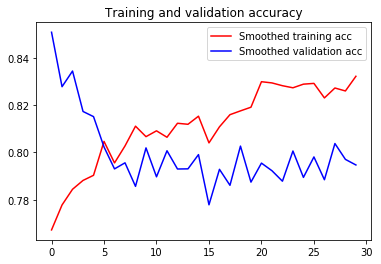

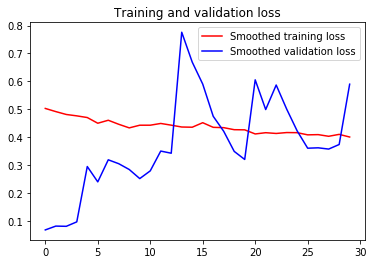

In [13]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Which models presented the smallest absolute difference between accuracy and loss of train and validation data?

In [14]:
df_results_highest_top10 = df_results.sort_values('train_acc', ascending=False).head(10)

In [15]:
df_results_highest_top10.sort_values(['diff_loss','diff_acc'])

,model,approach,train_acc,train_loss,val_acc,val_loss,diff_loss,diff_acc
118,MobileNetV2,feature extraction without data augmentation GAP,0.845485,0.370127,0.805380,0.452934,0.082807,0.040105
59,InceptionV3,feature extraction without data augmentation FC,0.848054,0.350319,0.783228,0.483956,0.133637,0.064826
61,InceptionV3,feature extraction without data augmentation FC,0.857736,0.327100,0.792722,0.492490,0.165391,0.065014
103,MobileNetV2,feature extraction without data augmentation FC,0.856550,0.347916,0.799051,0.518565,0.170649,0.057499
8,Baseline,class weight auto,0.844500,0.381493,0.745935,0.200384,0.181109,0.098565
60,InceptionV3,feature extraction without data augmentation FC,0.856155,0.335528,0.786392,0.532702,0.197174,0.069763
104,MobileNetV2,feature extraction without data augmentation FC,0.862478,0.330303,0.802215,0.541360,0.211057,0.060263
5,Baseline,class weight auto,0.862000,0.367919,0.751016,0.018841,0.349078,0.110984
29,Baseline,class weight auto,0.857000,0.362196,0.785282,1.455268,1.093072,0.071718
20,Baseline,class weight auto,0.873000,0.352127,0.827621,1.748369,1.396242,0.045379


MobileNetV2 using feature extraction without data augmentation with a GAP classifier was the best result taking into account train and validation accuracy and smallest absolute difference in loss and accuracy between validation and train data.

### MobileNetV2	feature extraction without data augmentation GAP	

In [16]:
# load model

from keras.models import load_model

load_model("../models/MobileNetV2_model_firebreak_detection_GAP_fine_tuning.h5").summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 887,361
Non-trainable params: 1,371,904
_________________________________________________________________


In [17]:
file = 'MobileNetV2_fire_break_feature_extraction_without_data_augmentation_GAP_history.csv'
df_MobileNetV2 = pd.read_csv(folder+file)

df_MobileNetV2 = add_info(df_MobileNetV2,folder+file)
df_MobileNetV2.head().sort_values('train_acc', ascending=False)

,model,approach,train_acc,train_loss,val_acc,val_loss,diff_loss,diff_acc
4,../history/MobileNetV2,feature extraction without data augmentation GAP,0.822960,0.420610,0.797468,0.460860,0.040250,0.025492
3,../history/MobileNetV2,feature extraction without data augmentation GAP,0.819206,0.424893,0.802215,0.461608,0.036715,0.016990
2,../history/MobileNetV2,feature extraction without data augmentation GAP,0.811697,0.436588,0.797468,0.464961,0.028373,0.014229
1,../history/MobileNetV2,feature extraction without data augmentation GAP,0.799842,0.460437,0.803797,0.465906,0.005469,0.003956
0,../history/MobileNetV2,feature extraction without data augmentation GAP,0.769413,0.530410,0.799051,0.485410,0.044999,0.029637


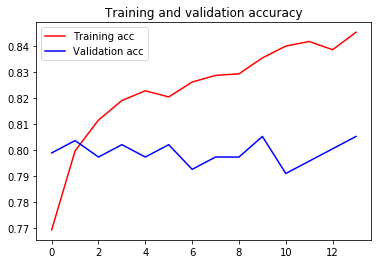

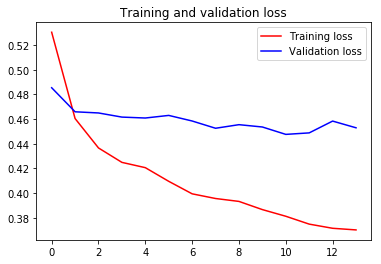

In [18]:
import matplotlib.pyplot as plt

acc = df_MobileNetV2['train_acc']
val_acc = df_MobileNetV2['val_acc']
loss = df_MobileNetV2['train_loss']
val_loss = df_MobileNetV2['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

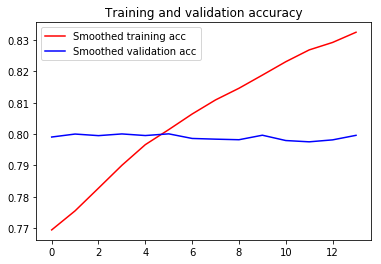

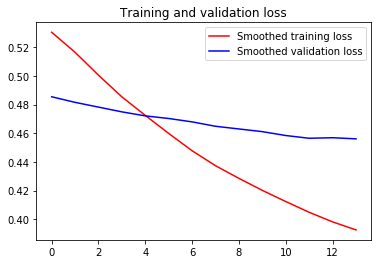

In [19]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()